# Exploration of the House Prices Dataset
This notebook explores the House Prices dataset from Kaggle. The goal is to understand the data before building any model. You will inspect variables, detect patterns, and identify potential issues such as missing values or outliers.

Each plot and statistic helps to understand features, describe different aspects of a house: structure, quality, location, and sale price.

Specific information about all the data can be found in `data_description.txt` but in the notebook i will also explain why we're exploring certain columns and what we're looking at.

The goal of this notebook is to: 
* Understand what each column represents and how it relates to price.
* Understand which variables show strong or weak influence.
* Understand where cleaning or transformation is needed.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

sns.set(style="whitegrid", palette="muted", font_scale=1.1)
warnings.simplefilter(action='ignore', category=FutureWarning)

# File descriptions
* **train.csv** - the training set
* **test.csv** - the test set
* **data_description.txt** - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
* **sample_submission.csv** - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

In [68]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [69]:
print(train_df.shape, test_df.shape)

(1460, 81) (1459, 80)


# Exploratory Data Analysis

In [70]:
display(train_df.head(3))
train_df.info()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

As expected, most columns are complete but there are some that contain missing values which is also understandable. The dataset contains columns like `PoolArea` and `PoolQC` which are only relevant for houses with a pool for example. Other examples of columns like this are:

* `LotFrontage`: Linear feet of street connected to property -> not all houses are connected to a street
* `Alley`: Type of alley access to property -> Na simply means "No alley access"
* `MasVnrType`: Masonry veneer type -> Not all houses are made out of "Brick" therefore Na stands for None
* `BsmtQual`: Height of the basement -> Alot of houses don't have basements
* `FirePlaceQu`: Fireplace quality -> Same as BsmtQual

There are interesting statistics to look at if they aren't Na but for most of them they simply don't apply to alot of houses. But it's still important to note the fact they exist and why they are Na.

The rest of the data types show a mix of numeric and categorical values:

* 35 integer columns
* 3 float columns
* 43 categorical columns

Many **categorical features** describe house characteristics such as style, quality, and neighborhood. **Numeric** columns often represent sizes, counts, or years.

Since `SalePrice` is our targer variable I'm gonna dive deeper into it, starting with the distribution. For reference SalePrice has the following meaning:

"*the property's sale price in dollars. This is the target variable that you're trying to predict.*"

## SalePrice Exploration
SalePrice is our target variable, it's what we eventually want to predict. So it's important we have a through understand of the target variable, what it means, see if the data is skewed, detect outliers, what values the dataset contains etc.

It gives you and intuition about how house prices are spread before looking at any of the other features that explain them.

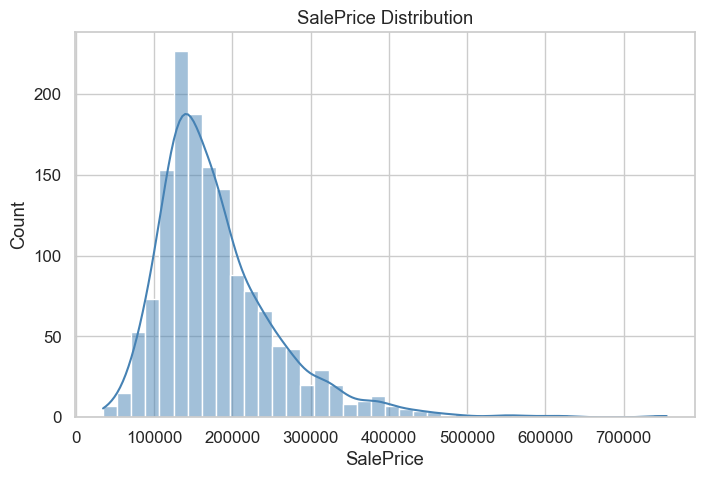

In [71]:
# Target Variable Overview
plt.figure(figsize=(8,5))
sns.histplot(train_df["SalePrice"], kde=True, bins=40, color="steelblue") # type: ignore
plt.title("SalePrice Distribution")
plt.show()

### What we see
The histogram shows the SalePrice distribution across all the houses in the dataset, which gives us some insight:

* Most houses sell between 100,000 and 200,000
* The distribtuion is right-skewed, which means a few shouses sell for a much higer price instead of lower.
* There seem to not be any visible gaps, but there are some extreme high-price values that could be outliers

This plot helps to see what way the data is skewed, in this case right-side. Which gives us an insentive to look at the rows with the high SalePrice to understand why they're higher. It also helps us understand the price range we're trying to predict later on.

Since im interested in what these left- and right-sided outliers contain i will firstly look at those rows.

### Left- and Right Sided Outlier
To understand these outliers were also looking at `Neighborhood`, `OverallQual`, and `GrLivArea`.

* `Neighborhood` shows the house location, which strongly affects value. **In the feature exploration boxplot below here we can see which neighborhoods hold more and less value.**
* `OverallQual` rates the overall material and finish quality from 1 to 10. High scores signal premium homes; low scores mark basic or worn ones.
* `GrLivArea` measures the above-ground living area in square feet. Larger homes tend to sell for more.

These three columns give context for why a house might be unusually cheap or expensive.

In [72]:
# Houses with unusually low sale prices
low_outliers = train_df[train_df['SalePrice'] < 80000]
print("Number of low-price outliers:", len(low_outliers))
low_outliers[['Id', 'SalePrice', 'Neighborhood', 'OverallQual', 'GrLivArea']]

Number of low-price outliers: 35


,Id,SalePrice,Neighborhood,OverallQual,GrLivArea
29,30,68500,BrkSide,4,520
30,31,40000,IDOTRR,4,1317
155,156,79000,Edwards,6,1096
242,243,79000,OldTown,5,1440
250,251,76500,BrkSide,3,1306
264,265,73000,OldTown,5,764
329,330,78000,IDOTRR,5,1192
375,376,61000,Edwards,1,904
383,384,76000,SawyerW,6,784
398,399,67000,IDOTRR,5,1077


Most of these homes are in older or lower-value neighborhoods. Many `OverallQual` are also between 2 and 5 which suggest a lower build quality. The `GrLivArea` is usually also small, often under 1000 square feet. 

These rows likely represent older, smaller homes or porperties in poor condition. Some extreme cases like *IDOTRR* or *BkrSide* coudl also suggest foreclosures or teardown-level properties.

These outliers pull the left tail of the price distribution downward. They reflect legitimate but low-value homes rather than data errors.

In [73]:
# Houses with unusually high sale prices
high_outliers = train_df[train_df['SalePrice'] > 450000]
print("Number of high-price outliers:", len(high_outliers))
high_outliers[['Id', 'SalePrice', 'Neighborhood', 'OverallQual', 'GrLivArea', 'Fireplaces', 'PoolArea']]

Number of high-price outliers: 14


,Id,SalePrice,Neighborhood,OverallQual,GrLivArea,Fireplaces,PoolArea
178,179,501837,StoneBr,9,2234,1,0
185,186,475000,OldTown,10,3608,2,0
440,441,555000,NridgHt,10,2402,2,0
591,592,451950,NridgHt,10,2296,1,0
691,692,755000,NoRidge,10,4316,2,0
769,770,538000,StoneBr,8,3279,1,0
798,799,485000,NridgHt,9,3140,2,0
803,804,582933,NridgHt,9,2822,1,0
898,899,611657,NridgHt,9,2364,2,0
1046,1047,556581,StoneBr,9,2868,1,0


Mirroring the low-price homes, these houses are in highstatus neighborhoods such as NridgHt, NoRidge, or StoneBr. Their `OverallQual` is also between 9 or 10 with one 8 which means top-tier construction and finish. They `GrLivArea` also exceeds 2,000 square feet, some also reaching over 4,000.

Which means these are large, high-quality homes in prime areas. The prices above 600,000 likely represent luxury: amount of fireplaces, the pool area etc.

These points extend the right tail of the distribution. They are not errors.

---

## Feature Exploration Neighborhood and OverallQual
To see what the Neighborhoods mean exactly in the left- and right-sided outliers this boxplot gives us more information. Same with OverallQual. Using that information we can draw better conclusions with the lower and higher outliers.

Number of categorical features: 43


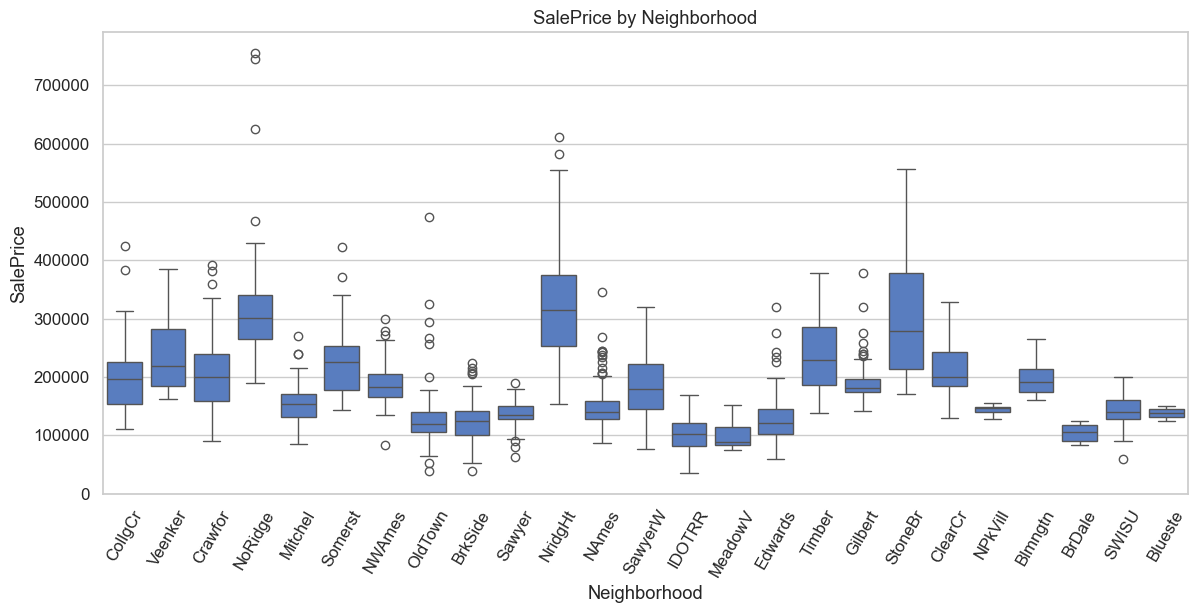

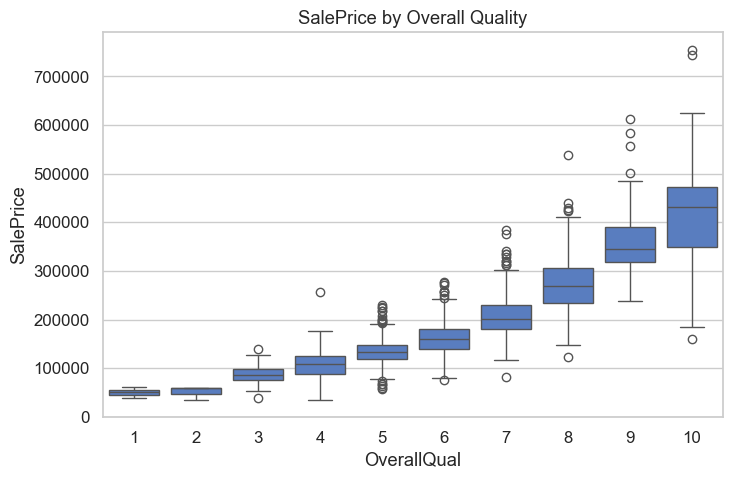

In [74]:
# categorical feature exploration
cat_feats = train_df.select_dtypes(include=["object"]).columns.tolist()
print(f"Number of categorical features: {len(cat_feats)}")

# Neighborhood and OverallQual are strong predictors
plt.figure(figsize=(14,6))
sns.boxplot(x="Neighborhood", y="SalePrice", data=train_df)
plt.xticks(rotation=60)
plt.title("SalePrice by Neighborhood")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x="OverallQual", y="SalePrice", data=train_df)
plt.title("SalePrice by Overall Quality")
plt.show()

## Log-transform

Next I want to look at the log-transformed SalePrice values. What this does is take the logarithm of SalePrice, this rescales it so theres no large gap between cheap and expensive homes. So that the influence on the model becomes a bit more balanced.

We're doing this because we noticed the prices were a bit right-skewed, but its also important to experiment with logarithms. Using it could help you:

* Stabilize variances, which makes the relationships with certain features moree lineair.
* Could improve model performance for regression algorithms that assume normally distributed errors
* Could make visualisation and correlation analysis more reliable

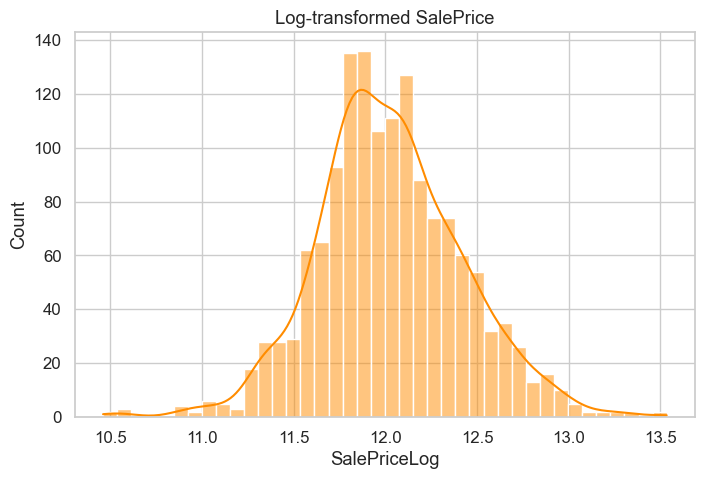

In [75]:
# Log-transform
train_df["SalePriceLog"] = np.log1p(train_df["SalePrice"])
plt.figure(figsize=(8,5))
sns.histplot(train_df["SalePriceLog"], kde=True, bins=40, color="darkorange") # type: ignore
plt.title("Log-transformed SalePrice")
plt.show()

### What we see
After applying the logarithm, the distribution becomes more symmetric and closser to a bell-shaped curve. The extreme values on both the left- and right are compressed, reducing their influence. Most houses now cluster around a central value between 11.5 and 12.5 which corresponds roughly to 100,000-250,000.

---

## Missing values

Just like any EDA its also important topics like missing values like we did before using `.info()`. But this print and plot gives us a bit more detail. This helps us identify columns that might need to be dropped due to excessive missing values. Spot patterns such as garages, basements, fireplaces etc. missing together. 

It essentially helps us decide between imputing, removing or flagging data/ columns.

,missing_count,missing_%
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


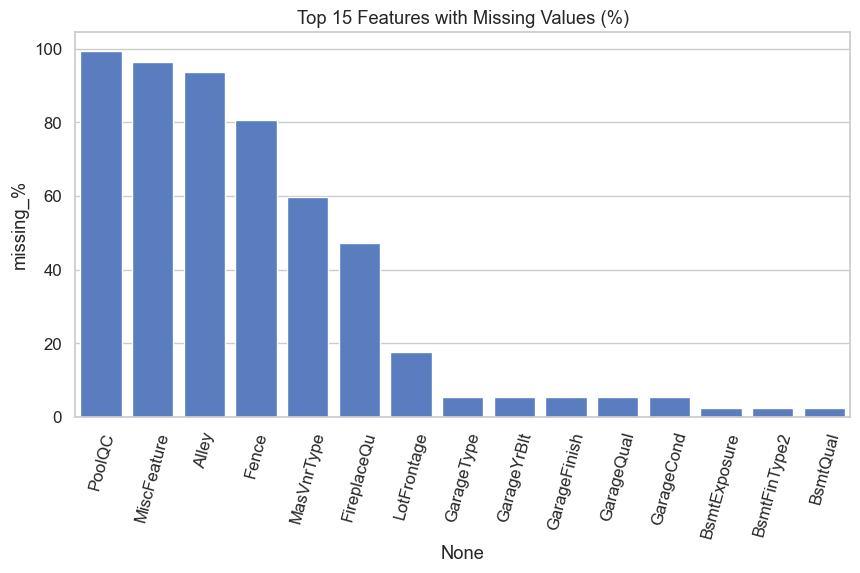

In [76]:
# Missing values
missing = (
    train_df.isna().sum()
    .to_frame("missing_count")
    .query("missing_count > 0")
    .sort_values("missing_count", ascending=False)
)
missing["missing_%"] = (missing["missing_count"] / len(train_df)) * 100
display(missing.head(15))

plt.figure(figsize=(10,5))
sns.barplot(x=missing.head(15).index, y=missing.head(15)["missing_%"])
plt.xticks(rotation=75)
plt.title("Top 15 Features with Missing Values (%)")
plt.show()


### What we see
`PoolQC`, `MiscFeature`, and `Alley` have missing rates above 90%. This means almost all houses lack pool quality data, miscellaneous features, or alley access.

`Fence` and `MasVnrType` also have large gaps, above 50%. Features like `FireplaceQu` and `LotFrontage` have moderate missingness.

This alines with our earlier findings, but it gives us a good list of columns and their missing percentages. We already saw that Pools are more frequent with expensive outlier houses. So it could be smart to leave that column out of the regression.

---

## Numerical Features and Correlations

Since we want to know more about correlations between SalePrice and other variables we want to analyze the feature correlations to understand what drives house prices. This helps us identify which features would be most predictive for regression models. And it helps spot the more redudant and weakly related features.

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

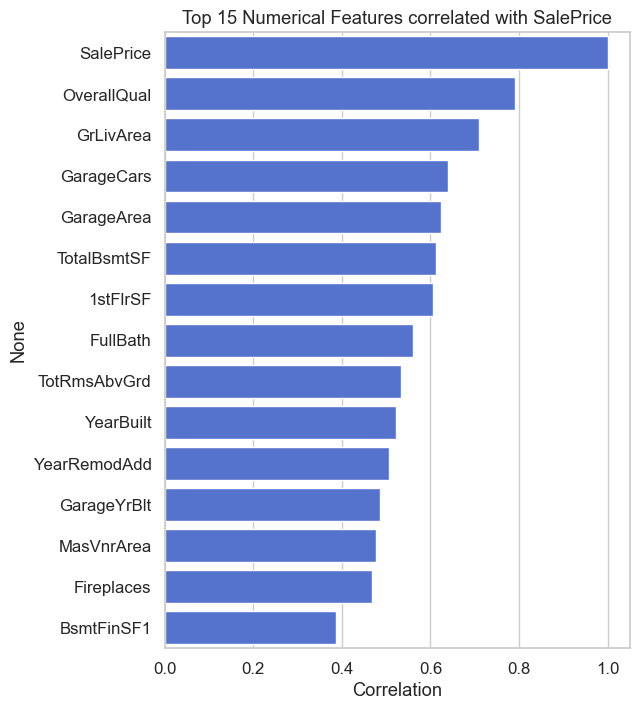

In [77]:
# numerical feature exploration
numeric_feats = train_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_feats.remove("SalePrice")
numeric_feats.remove("SalePriceLog")

# correlation print with SalePrice
corr = train_df[numeric_feats + ["SalePrice"]].corr()["SalePrice"].sort_values(ascending=False)
top_corr = corr.head(15)
display(top_corr)

plt.figure(figsize=(6,8))
sns.barplot(x=top_corr.values, y=top_corr.index, color="royalblue")
plt.title("Top 15 Numerical Features correlated with SalePrice")
plt.xlabel("Correlation")
plt.show()

### What we see

`OverallQual` has the strongest correlation (0.79). This means higher material and finish quality strongly increase price. `GrLivArea`, `GarageCars`, `GarageArea`, and `TotalBsmtSF` also have high positive correlations, all above 0.6. Larger homes and garages lead to higher prices.

Features like `YearBuilt` and `YearRemodAdd` show that newer or recently renovated homes sell for more. Lower-ranked but still relevant variables include `Fireplaces` and `BsmtFinSF1`, which show moderate positive relationships.

---

## Example Scatterplots

To delve more into individual features and how they influence the price directly theres a few scatterplot starting off with some interesting variables like:

`GrLivArea`, `TotalBsmtSF`, `1stFlSf`, `YearBuilt`, `OverallQual` and `GarageArea`.

This can confirm which relationships are linear and suitable for the regression. It also allows us to spot more outliers or irregular points that could distort the model. 

In short, these plots show that space, quality, and modernity have the strongest visual and statistical connection to sale price, reinforcing earlier correlation findings.

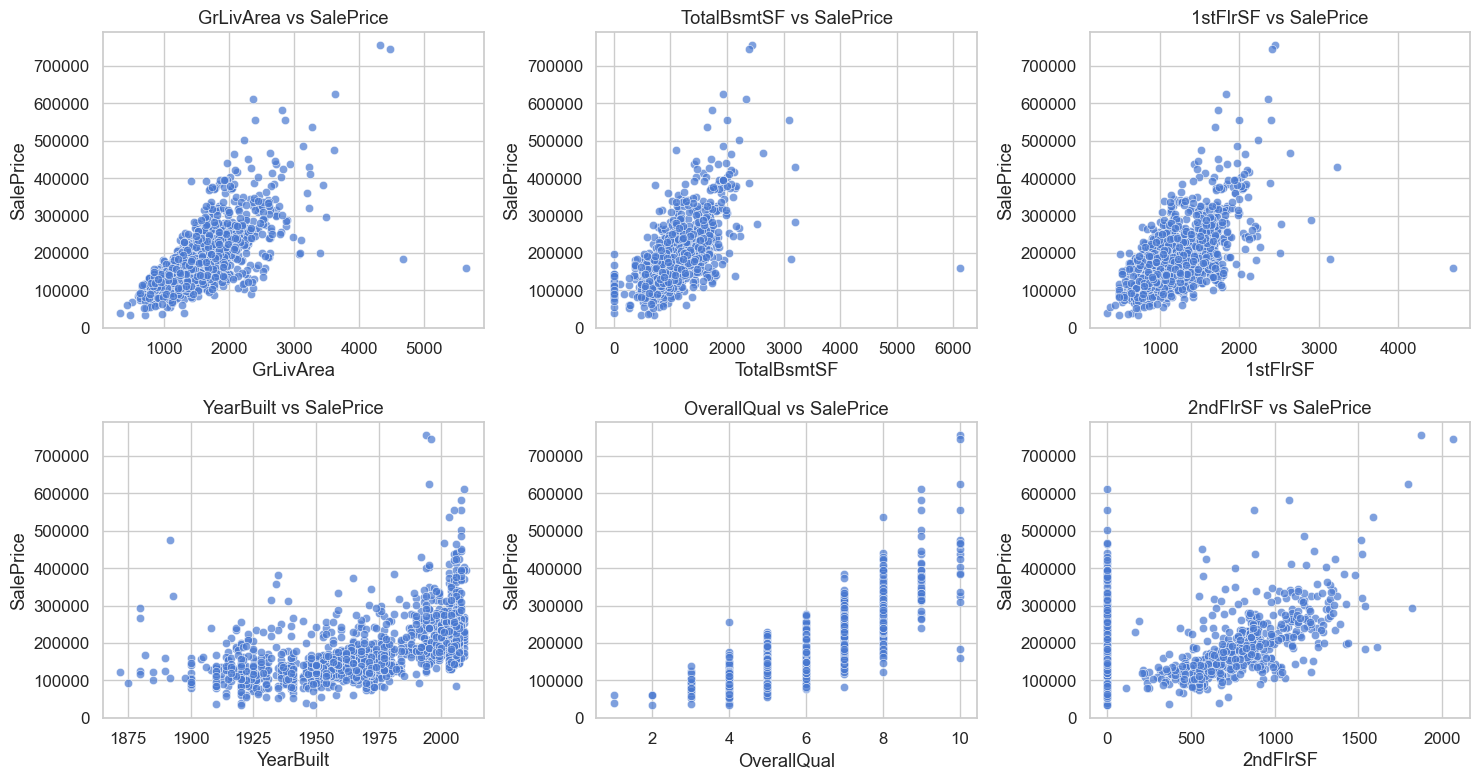

In [78]:
# esxample scatterplots for certain key features
key_feats = ["GrLivArea", "TotalBsmtSF", "1stFlrSF", "YearBuilt", "OverallQual", "2ndFlrSF"]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, col in enumerate(key_feats):
    sns.scatterplot(
        data=train_df, x=col, y="SalePrice", ax=axes[i//3, i%3], alpha=0.7
    )
    axes[i//3, i%3].set_title(f"{col} vs SalePrice")
plt.tight_layout()
plt.show()

### What we see
`GrLivArea`, `TotalBsmtSF`, and `1stFlrSF` show a clear positive trend: larger houses and basements mean higher prices. YearBuilt also trends upward: newer homes tend to sell for more.

`OverallQual` shows a strong step-like pattern, where higher quality levels sharply increase price.

Some scatter plots reveal a few outliers, for example, very large houses with lower prices, which could be unusual sales.

---

## Outliers GrLivArea vs SalePrice

The outliers with the LivArea and SalePrice were interesting. Especially the ones that sold below 200,000 while being above 4500 square feet. Thats why i want to zoom in on those outliers.

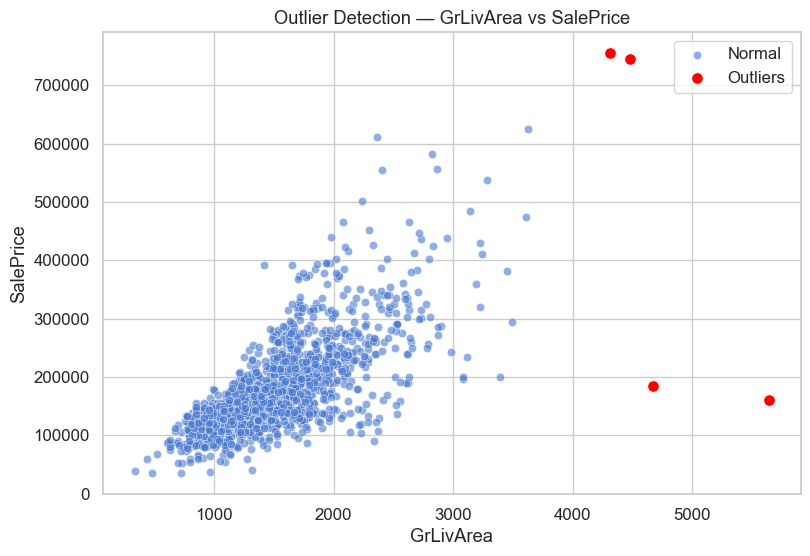

In [79]:
# Define outlier threshold for GrLivArea
outlier_threshold = 4000

# Separate normal and outlier points
outliers = train_df[train_df['GrLivArea'] > outlier_threshold]
normal = train_df[train_df['GrLivArea'] <= outlier_threshold]

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(x=normal['GrLivArea'], y=normal['SalePrice'], label='Normal', alpha=0.6)
sns.scatterplot(x=outliers['GrLivArea'], y=outliers['SalePrice'], color='red', label='Outliers', s=70)
plt.title('Outlier Detection — GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.legend()
plt.show()

They few points in red have a very large living areas (above 4000 sq ft) but relatively low prices. These are potential outliers because their prices are much lower than expected for their size.

These outliers could reflect unusual market conditions, poor quality despite large size, or data entry errors. Hence why i want to see what the other variables look like with these outliers.

The columns im showing for context are:

* `OverallCond` shows general upkeep, not just material quality.
* `TotalBsmtSF` checks if the house has a finished or usable basement area.
* `GarageCars` and `GarageArea` reveal parking capacity.
* `FullBath` and `TotRmsAbvGrd` give living comfort details.
* `KitchenQual` often drives price strongly, even when the home is large.

In [80]:
outliers = train_df[train_df['GrLivArea'] > 4000]

# select columns that help explain why these are outliers
cols_to_show = [
    'SalePrice', 'GrLivArea', 'OverallQual', 'OverallCond',
    'Neighborhood', 'YearBuilt', 'TotalBsmtSF', 'GarageCars',
    'GarageArea', 'FullBath', 'TotRmsAbvGrd', 'KitchenQual'
]

# display them
display(outliers[cols_to_show])

,SalePrice,GrLivArea,OverallQual,OverallCond,Neighborhood,YearBuilt,TotalBsmtSF,GarageCars,GarageArea,FullBath,TotRmsAbvGrd,KitchenQual
523,184750,4676,10,5,Edwards,2007,3138,3,884,3,11,Ex
691,755000,4316,10,6,NoRidge,1994,2444,3,832,3,10,Ex
1182,745000,4476,10,5,NoRidge,1996,2396,3,813,3,10,Ex
1298,160000,5642,10,5,Edwards,2008,6110,2,1418,2,12,Ex


even with these colums to add context its still unusual why these houses sold for such a low price. The only column that kind of explains this is Neighborhood, `Edwards` is a bit on the lower end. But that it wouldn't make sense for houses of this size and quality to be sold for such a low `SalePrice` solely for the Neighborhood.

Thats why i've decided to note these rows to remove them from the model due to it making the model potentially biased by invalid data.

Becuase of this discovery i've also decided to dive a bit deeper into the outliers in `TotalBsmtSF` and `1stFlrSf`.

---

## TotalBsmtSF

I'm repeating the same proces as before, for context:

`TotalBsmtSF`: Total square feet of basement area

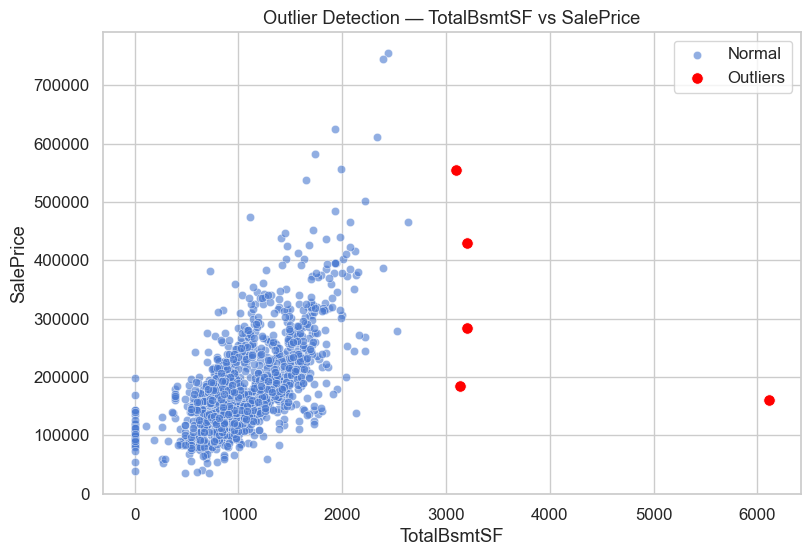

In [81]:
# Define outlier threshold for TotalBsmtSF
outlier_threshold = 3000

# Separate normal and outlier points
outliers = train_df[train_df['TotalBsmtSF'] > outlier_threshold]
normal = train_df[train_df['TotalBsmtSF'] <= outlier_threshold]

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(x=normal['TotalBsmtSF'], y=normal['SalePrice'], label='Normal', alpha=0.6)
sns.scatterplot(x=outliers['TotalBsmtSF'], y=outliers['SalePrice'], color='red', label='Outliers', s=70)
plt.title('Outlier Detection — TotalBsmtSF vs SalePrice')
plt.xlabel('TotalBsmtSF')
plt.ylabel('SalePrice')
plt.legend()
plt.show()

In [82]:
outliers = train_df[train_df['TotalBsmtSF'] > 3000]

# select columns that help explain why these are outliers
cols_to_show = [
    'SalePrice', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', 'OverallCond',
    'Neighborhood', 'YearBuilt', 'GarageCars',
    'GarageArea', 'FullBath', 'TotRmsAbvGrd', 'KitchenQual'
]

# display them
display(outliers[cols_to_show])

,SalePrice,GrLivArea,TotalBsmtSF,OverallQual,OverallCond,Neighborhood,YearBuilt,GarageCars,GarageArea,FullBath,TotRmsAbvGrd,KitchenQual
332,284000,1629,3206,8,5,NridgHt,2003,3,880,2,7,Gd
440,555000,2402,3094,10,5,NridgHt,2008,3,672,2,10,Ex
496,430000,3228,3200,8,5,NoRidge,1992,2,546,3,10,Gd
523,184750,4676,3138,10,5,Edwards,2007,3,884,3,11,Ex
1298,160000,5642,6110,10,5,Edwards,2008,2,1418,2,12,Ex


This confirms the last analysis, it shows the same properties in `Edwards`.

The other homes (332, 440, 496) fit the pattern: large basements, strong quality, and high prices. That means the problem is not large basements themselves, it’s those two Edwards houses that do not align with their features.



---

## 1stFlrSF

I'm repeating the same proces as before, for context:

`1stFlrSF`: First Floor square feet

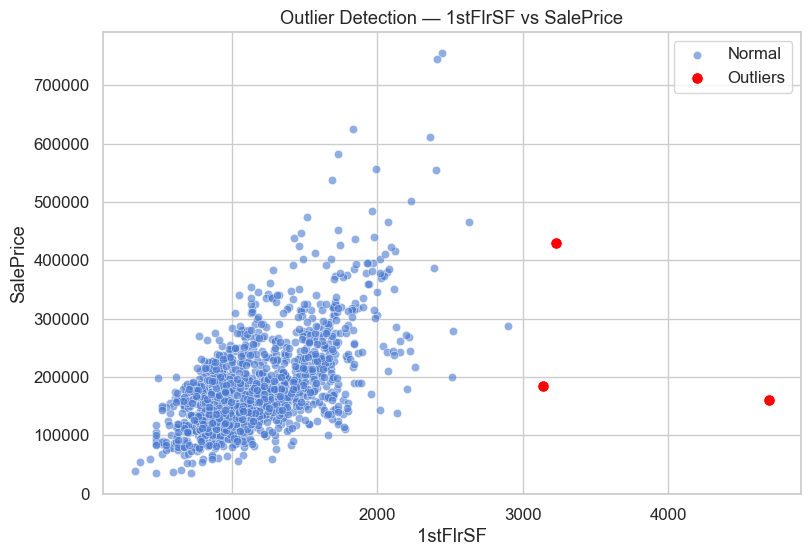

In [83]:
# Define outlier threshold for 1stFlrSF
outlier_threshold = 3000

# Separate normal and outlier points
outliers = train_df[train_df['1stFlrSF'] > outlier_threshold]
normal = train_df[train_df['1stFlrSF'] <= outlier_threshold]

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(x=normal['1stFlrSF'], y=normal['SalePrice'], label='Normal', alpha=0.6)
sns.scatterplot(x=outliers['1stFlrSF'], y=outliers['SalePrice'], color='red', label='Outliers', s=70)
plt.title('Outlier Detection — 1stFlrSF vs SalePrice')
plt.xlabel('1stFlrSF')
plt.ylabel('SalePrice')
plt.legend()
plt.show()

In [84]:
outliers = train_df[train_df['1stFlrSF'] > 3000]

# select columns that help explain why these are outliers
cols_to_show = [
    'SalePrice', '1stFlrSF', 'OverallQual', 'OverallCond',
    'Neighborhood', 'YearBuilt', 'GarageCars',
    'GarageArea', 'FullBath', 'TotRmsAbvGrd', 'KitchenQual'
]

# display them
display(outliers[cols_to_show])

,SalePrice,1stFlrSF,OverallQual,OverallCond,Neighborhood,YearBuilt,GarageCars,GarageArea,FullBath,TotRmsAbvGrd,KitchenQual
496,430000,3228,8,5,NoRidge,1992,2,546,3,10,Gd
523,184750,3138,10,5,Edwards,2007,3,884,3,11,Ex
1298,160000,4692,10,5,Edwards,2008,2,1418,2,12,Ex


The same Edwards properties are also coming up here along with property ID 496 again. The third point (Id 496) in NoRidge looks fine: large house, high price, consistent with others.

In [85]:
train_df = train_df.drop([523, 1298])